# Conditional GAN for time series generation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alexander/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

## Download data

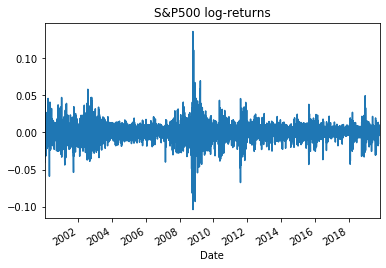

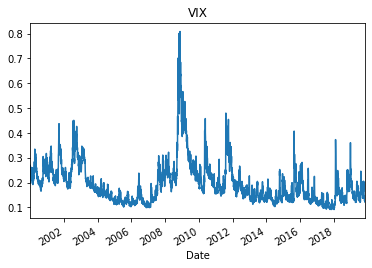

In [2]:
import datetime as dt
import pandas_datareader as pdr

## time range
start = dt.datetime(2000,1,1)
end = dt.datetime(2020,1,1)

## download data
sp500 = pdr.get_data_yahoo('SPY', start=start, end=end)
vix = pdr.get_data_yahoo('^VIX', start=start, end=end)

## compute returns
returns = np.log(sp500['Close']).diff()

## normalize vix
vix = vix['Close'] / 100.

## display time series
plt.figure()
returns.plot()
plt.title('S&P500 log-returns')
plt.show()
plt.figure()
vix.plot()
plt.title('VIX')
plt.show()

## Prepare data

In [3]:
n_day = 10 ## number of days to simulate

n_ts = returns.shape[0]
r_vix = vix[1:n_ts-n_day] ## real vix values
r_lr = [] ## real returns
for i in range(1, n_ts-n_day):
    r_lr.append(returns[i:(i+n_day)])
r_lr = np.asarray(r_lr)

x_train, y_train = r_lr, r_vix

## Model builders

In [ ]:
from keras.models import Model
from keras.layers import Activation, Dense, Input
from keras.layers.merge import concatenate

## inputs = noise
## labels = condition (= vix value here)
## nday = number of returns to generate
def build_generator(inputs, labels, n_day, n_layer=3, h_dim=30):
    
    ## concatenate inputs
    x = None ## TODO
    
    # ANN layer sizes
    hsize = None ## TODO
    
    ## make layers
    ## TODO
    
    ## output layer
    x = None ## TODO
    
    # input is conditioned by labels
    generator = None ## TODO
    
    return generator

def build_discriminator(inputs, labels, n_day, n_layer=3, h_dim=30):
    
    # ANN layer sizes
    hsize = None ## TODO
    
    ## concatenate inputs
    x = None ## TODO
    
    ## make layers
    ## TODO
    
    ## output layer
    x = None ## TODO
    
    # input is conditioned by labels
    generator = None ## TODO
    return generator

## Random labels and noise generator

In [ ]:
def random_labels_and_noise(y_train, batch_size, latent_size):
    ## bootstrap VIX values + plus uniform noise
    fake_vix = np.random.choice(y_train, batch_size) #+ np.random.uniform(-0.05, 0.05, size=batch_size) 
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
    return noise, fake_vix

## Build and train

In [ ]:
from keras.optimizers import RMSprop

## parameters
latent_size = 2
lr = 1e-4
decay = 6e-8
input_shape = None ## TODO
label_shape = None ## TODO

## build discriminator model
inputs = Input(shape=input_shape, name='discriminator_input')
labels = Input(shape=label_shape, name='class_labels')
discriminator = build_discriminator(inputs, labels, n_day)

## discriminator converges easily with RMSprop (original paper use Adam)
discriminator.compile(loss=None, ## TODO
                      optimizer=RMSprop(lr=lr, decay=decay),
                      metrics=['accuracy'])

## build generator model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
generator = build_generator(inputs, labels, n_day)

## build adversarial model = generator + discriminator
## freeze the weights of discriminator during adversarial training
discriminator.trainable = None ## TODO
outputs = discriminator([generator([inputs, labels]), labels])
combined = Model([inputs, labels],
                 outputs, name="combined")
combined.compile(loss=None, ## TODO
                 optimizer=RMSprop(lr=lr*0.5, decay=decay*0.5),
                 metrics=['accuracy'])

## models summaries
#discriminator.summary()
#generator.summary()
combined.summary()

## Training algorithm

In [ ]:
def get_random_batch(x_train, y_train, batch_size):
    train_size = x_train.shape[0]
    rand_indexes = np.random.randint(0, train_size, size=batch_size)
    x_batch = x_train[rand_indexes]
    y_batch = y_train[rand_indexes]
    return x_batch, y_batch

def train(models, data, params):
    ## the GAN models made with Keras
    generator, discriminator, combined = models
    
    ## real data
    x_train, y_train = data
    
    ## parameters
    batch_size, latent_size, train_steps, nd_steps, ng_steps = params

    losses = []
    for i in range(int(train_steps/(nd_steps + ng_steps))):
        
        ## batch dimensions
        batch_true = None ## TODO
        batch_fake = batch_size - batch_true
        
        ## randomly select real data
        real_ts, real_vix = get_random_batch(x_train, y_train, batch_true)
        
        ## generate fake data
        noise, fake_vix = random_labels_and_noise(y_train, batch_fake, latent_size)
        fake_ts = generator.predict([noise, fake_vix])
        
        ## real + fake = 1 batch
        x = np.concatenate((real_ts, fake_ts))
        labels = np.concatenate((real_vix, fake_vix))

        ## label real == 1.0 and fake == 0
        y = np.ones([batch_size, 1])
        y[batch_true:, :] = 0.0
        
        ## train the discriminator
        for _ in range(nd_steps):
            dloss, dacc = None ## TODO: use train_on_batch
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, dloss, dacc)

        ## generate fake data again (could re-use the ones above)
        noise, fake_vix = random_labels_and_noise(y_train, batch_size, latent_size)
        y = np.ones([batch_size, 1])
        
        ## train the generator
        for _ in range(ng_steps):
            gloss, gacc = None ## TODO: use train_on_batch
        log = "%s [generator loss: %f, acc: %f]" % (log, gloss, gacc)
        
        if i % 100 == 0:
            print(log)
        
        ## save all losses
        losses.append([i, i*((nd_steps + ng_steps)), dloss, gloss])
            
    return losses

In [ ]:
## parameters
batch_size = 256
train_steps = int(1e4)
nd_steps = 1
ng_steps = 1

## train discriminator and adversarial networks
models = (generator, discriminator, combined)
data = (x_train, y_train)
params = (batch_size, latent_size, train_steps, nd_steps, ng_steps)
losses = train(models, data, params)

In [ ]:
losses = pd.DataFrame(losses, columns=['Iteration', 'Step', 'loss discriminator', 'loss generator'])

plt.plot('Step', 'loss discriminator', data=losses)
plt.plot('Step', 'loss generator', data=losses)
plt.xlabel('Step')
plt.legend()
plt.title('Training Losses')
plt.ylim(0,1)
plt.show()

## Test models

In [ ]:
n_plot = 100

def plot_ts(noise_input, noise_vix):
    gen_ts = generator.predict([noise_input, noise_vix])
    plt.figure()
    plt.ylim(-0.1, 0.1)
    for i in range(n_plot):
        plt.plot(gen_ts[i])
    plt.show()
    
noise_input = np.random.uniform(-1.0, 1.0, size=[n_plot, latent_size])    

plot_ts(noise_input, np.array([0.1] * n_plot))
plot_ts(noise_input, np.array([0.9] * n_plot))



In [ ]:
n_pts = 1000

x_true, y_true = get_random_batch(x_train, y_train, n_pts)
scores_true = discriminator.predict([x_true, y_true])
noise_fake, y_fake = random_labels_and_noise(y_train, n_pts, latent_size)
scores_fake = combined.predict([noise_fake, y_fake])

scores = np.hstack([scores_true, scores_fake])
plt.hist(scores)
plt.legend(['True', 'Fake'])
plt.title('Scores historgram')
plt.ylabel('Number of obs.')
plt.xlabel('Score')
plt.show()